# General Instructions

This assignment deals with word embeddings and neural networks.
Q4 may require contents taught in the lecture of February 12th.

Please give access to the instructors, and send a link to your copy of this notebook on Colab, **NOT** a .ipynb file.

**Updated Timing Estimates**: We expect the code runtime in each subquestion to be individually less than 15 minutes.
If you are experiencing a considerably longer runtime (e.g. several hours), you may need to make your code more efficient by using numpy broadcasting. Note that we do NOT expect you to parallelize python `for` loops in other ways (like using multithreading in python). We also do not expect you to use GPUs.

# Q1. Co-occurrence Embeddings (20 points)
Consider the technique of embedding words to vectors using counts of context co-occurrences, as taught in class.

Here we will implement this technique to find embeddings for each unique word in the Shakespeare corpus. Later in the assignment, we will compare them to word embeddings learnt using Word2vec.



## Q1.1 Co-occurrence + PPMI (15 points)
Fill in the code to complete the implementation of calculating co-occurrences and also weighing them by PPMI (Positive Pointwise Mutual Infomation) as taught in class. All assert statements should pass. Use a span length of `5` words on each side (total window length 11) as already set default in the starter code provided.

Note: Use log base e in your PPMI formula as mentioned in class slides.

In [ ]:
# Download data - do not change
import requests
import numpy as np
from tqdm.notebook import tqdm
import time
from scipy.special import expit as sigmoid

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
response.raise_for_status() # Raise an exception for invalid HTTP status codes
text_data = response.text
len(text_data), text_data[:100]

(1115394,
 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou')

In [ ]:
# preprocessing - do not change
text_data = response.text
text_data = text_data.replace(',', ' , ').replace('.', ' . ').replace('?', ' ? ').replace('!', ' ! ')
text_data = text_data.replace('  ', ' ')
text_data = text_data.replace('\n\n', '\n').replace('\n', ' </s> <s> ')
text_data = '<s> ' + text_data + ' </s>'
len(text_data), text_data[:100]

(1451204,
 '<s> First Citizen: </s> <s> Before we proceed any further , hear me speak .  </s> <s> All: </s> <s> ')

In [ ]:
data = text_data.split(' ')
vocab = list(set(data))
revmap = {v:k for k, v in enumerate(vocab)} # dictionary to map words to indices
data_indices = [revmap[cont] for cont in data]

In [ ]:
counts = np.zeros(shape = (len(vocab), len(vocab)))
assert counts.shape == (18118, 18118)
span_length = 5
start_time = time.time()

# IMPLEMENT HERE

for i, word in tqdm(enumerate(data), total = len(data)):
  # Hint: calculate co-occurrences in each window
   word_index = revmap[word]
   wind_start = max(0, i - span_length)
   wind_end = min(len(data), i + span_length + 1)

   for j in range(wind_start, wind_end):
        if i != j: # Do not count the target word!
          context_word = data[j]
          context_index = revmap[context_word]
          counts[word_index, context_index] += 1

word_count = np.sum(counts)
p_word = np.sum(counts, axis = 1) / word_count
p_context = np.sum(counts, axis = 0) / word_count

# Hint: calculate PPMI values using co-occurrences
ppmi = np.maximum(np.log((counts / word_count) / (p_word[:, None] * p_context[None, :])), 0)
ppmi[np.isnan(ppmi)] = 0.0
ppmi[counts == 0] = 0
# Hint: Find L2 norms to convinently calculate cosine similiarity scores
ppmi_norms = np.linalg.norm(ppmi, axis = 1)

### END OF IMPLEMENTATION ####
print("--- %s seconds ---" % (time.time() - start_time))
# Note down this Training Time

assert ppmi.shape == (len(vocab), len(vocab))
assert counts[revmap['First'],revmap['Citizen:']] == 44.
#assert round(ppmi[revmap['First'],revmap['Citizen:']],7) == 4.024266 # UPDATE: earlier said 7.05e-05, sorry!
np.testing.assert_allclose(ppmi[revmap['First'], revmap['Citizen:']], 4.024266, rtol = 1e-5)

  0%|          | 0/316243 [00:00<?, ?it/s]

<ipython-input-28-c3975290e69f>:25: RuntimeWarning: divide by zero encountered in log
  ppmi = np.maximum(np.log((counts / word_count) / (p_word[:, None] * p_context[None, :])), 0)


--- 22.67564034461975 seconds ---


## Q1.2 Nearest Neighbours (5 points)
Implement the function `get_nearest_neighbours` which given a target word (e.g., `eye`) or a vector (e.g., `[0.123, 1.993, ...]` as well as a 2D array `vectors` and the corresponding list of words `vocab`, returns `top_k` words that are most similar to the target vector in the embedding space, as measured by cosine similarity. Note that the closest word to the vector of `eye` must be `eye`.

In [ ]:
def get_nearest_neighbours(word_or_vector, vectors = ppmi, top_k = 5, vocab = vocab, norms = ppmi_norms):
  # IMPLEMENT HERE
  # Hint: L2 norms can be used for ease of calculating cosine similarity.
  # Hint: avoid iterating over vocabulary and use np.dot matrix multiplication.
  # Hint: sort by cosine similarity scores.
  # Check if input is a word or a vector
  if isinstance(word_or_vector, str):
        word_index = revmap[word_or_vector]
        target = vectors[word_index]
  else:
        target = np.array(word_or_vector)

  norm_target = np.linalg.norm(target)

  if norm_target > 0:
        target = target / norm_target

  cosine_similarities = np.dot(vectors, target) / (norms * norm_target)

  top_k_indices = np.argsort(-cosine_similarities)[:top_k]

  nearest_neighbours = [vocab[ele] for ele in top_k_indices]

  return nearest_neighbours

In [ ]:
get_nearest_neighbours('he')
assert 'he' in get_nearest_neighbours('he')

Here we will evaluate the embeddings on Analogy Task. You do not need to implement anything in this subsection.
Do not be concerned if your output results in a low score. Hit@100 is a metric which checks whether the ground truth answer was among the top 100 predictions made by a model.

**Do note down the time taken to run inference over the benchmark, and the final Hit@100 scores.**


In [ ]:
# Download and preprocessing data - do not change
import requests
import numpy as np
from tqdm.notebook import tqdm

url = "http://download.tensorflow.org/data/questions-words.txt"
response = requests.get(url)
response.raise_for_status() # Raise an exception for invalid HTTP status codes
analogy = response.text.split('\n')

# filtering out analogies that do not exist in our vocabulary
task = []
for line in tqdm(analogy, total = len(analogy)):
  row = line.split(' ')

  if len(row) != 4 or line.startswith(':'):
    continue

  if sum(_ in vocab for _ in row) == 4:
    task.append(row)

len(task), task[-1]

  0%|          | 0/19559 [00:00<?, ?it/s]

(2396, ['write', 'writes', 'work', 'works'])

In [ ]:
# Inference over Analogy Benchmark - do not change
acc = 0.

for a, b, c, d in tqdm(task): # Note down this Inference Time
  d_ = get_nearest_neighbours(word_or_vector = ppmi[revmap[a]] + ppmi[revmap[b]] - ppmi[revmap[c]], top_k = 100)

  if d in d_:
    acc += 1

acc/len(task)

  0%|          | 0/2396 [00:00<?, ?it/s]

0.008764607679465776

# **Q2.** Word2vec Gradient Derivation (15 points)

Remember the negative sampling loss function for Word2vec from the [lecture](https://drive.google.com/file/d/1xN5FiqtutlFrhID64qDGA3DqaZMIZfMh/view). Given the target word embedding $w$, context word embedding $c_\text{pos}$ from positive examples, and $K$ noise word embeddings $c_\text{neg$_i$}$ from negative examples,

$L = - [\log \sigma(w.c_\text{pos})+\Sigma_{i=1..K} \log \sigma(-w.c_\text{neg$_i$})]$

where $\sigma$ is the sigmoid function.

## ***Q2.1*** Derive the following gradients. (9 points)
**Hint:** First show that $\frac{\partial \sigma(x)}{\partial x} = \sigma(x) (1 - \sigma(x))$, and then use this throughout your derivations. Also, if you're not comfortable with LaTeX, feel free to write your answer on a sheet of paper and upload an image here.

$\frac{∂ L}{∂ w}$

$\frac{∂ L}{∂ c_\text{pos}}$

$\frac{∂ L}{∂ c_\text{neg$_i$}}$

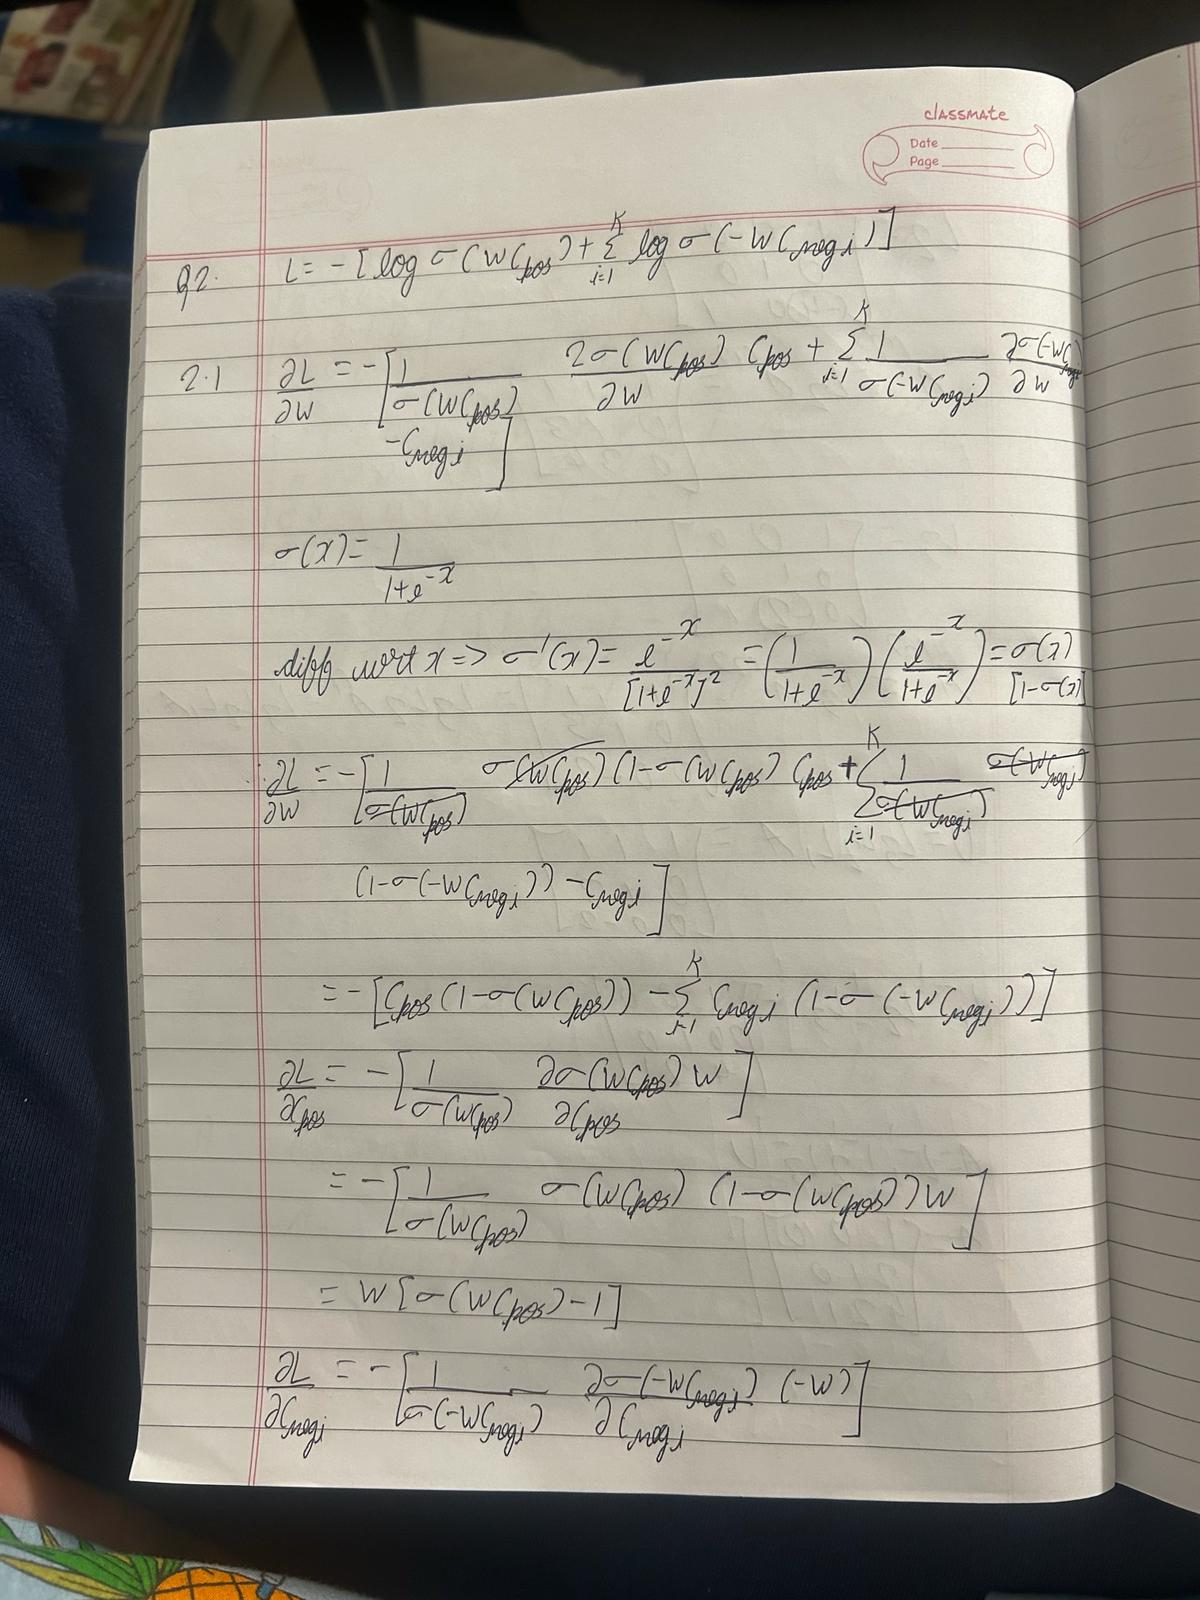

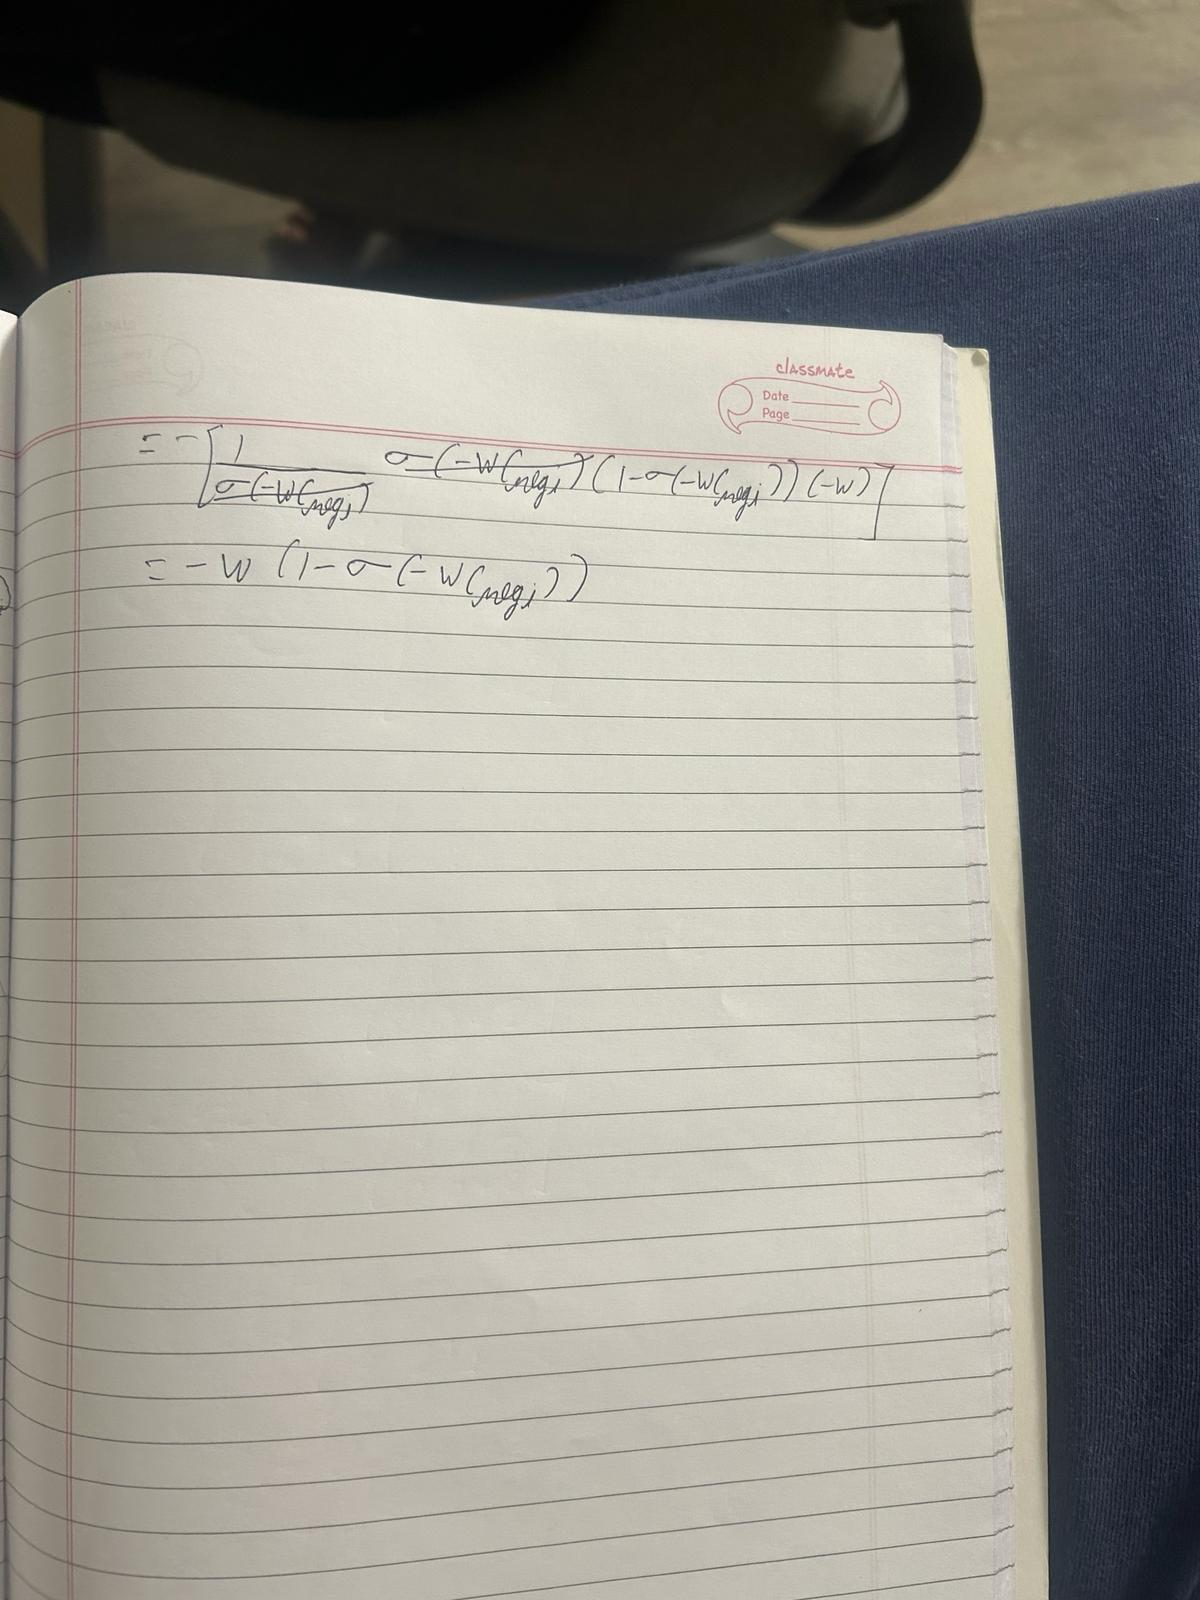

## ***Q2.2*** In your own words, describe intuitively how embeddings change when updated using SGD under the gradients above (no additional equations besides the gradients above required, description in words is enough). (3 points)

SGD will update the embeddings based on the learning rate. It the push the embeddings towards the local minima (when we equate the above partial derivates to zero) which is the opposite direction of the gradient. It essentially works has a closed loop network with negative feedback.

## ***Q2.3*** Why is negative sampling required? What happens if we solely rely on positive examples? (3 points)

If negative sampling is not done, then the model would have only positive samples and the probabilities would be highly biased. If the model is trained only with positive samples, then the model would not be able to generalize. The model would be predict words accurately. If the model encounters a negative word in the testing set, then the model would not be able to predict any word.

# Q3. Learn Word2Vec Embeddings (30 points)

Here we will convert the above equations into code and learn word2vec embeddings for each word. We will then compare these embeddings to those learnt using PPMI in Q1.

## Q3.1 Learning Word2vec (15 points)

Implement the Word2Vec as taught in class. Use a span length of `5` words on each side (total window length 11), `50` dimensions per embeddings, `0.01` learning rate, `15` negative samples per target word, and `500_000` number of iterations or trainig updates, as already set default in the starter code provided.

While calculating the loss explicitly is not needed to find gradient updates, we require you to calculate it so we can log it every 10K steps (code already provided - do not change). This will help track the loss as it goes down over training steps.

Hint: Do not try to find real negatives for a given context, instead randomly sample 15 words from the vocabulary to use as negative samples, and given the size of the vocabulary, it is very unlikely to include a word among the 11 context words.

**Updated Hint**: Also optionally do not try to find samples without replacement. You can use `np.random.randint` to instead sample with replacement, which is much more efficient hence brings down training time.



In [ ]:
import scipy.special
import numpy as np

D = 50 # embedding_dimensions
w_vectors = np.random.rand(len(vocab), D) # target
c_vectors = np.random.rand(len(vocab), D) # context and noise

In [ ]:
LR = 1e-2 # learning_rate
K = 15 # num_negatives
span_length = 5 # number of words before and after target in context
num_iter = 500_000 # number of iterations or update steps
negative_samples = 15
losses = []

for iter in tqdm(range(num_iter)): # # Note down this Training Time
  # IMPLEMENT HERE
  # Old (maybe unclear) Hint: Pick a random context from data.
  # Updated Hint: Pick a random target word from data, then iterate over each positive word in its context (using span_length)

  # Hint: Fetch target, context, and negatives from w_vectors and c_vectors.

  # Hint: Calculate gradient updates as derived in Q2.
  # Hint: You may use scipy.special.expit function to implement sigmoid.

  # Hint: Apply gradient updates to parts of w_vectors and c_vectors properly

  # loss = ... # Calculate loss
  # losses.append(loss)
  pred_index = np.random.randint(span_length, len(data_indices) - span_length)
  target = data_indices[pred_index]
  context_indices = [index for index in range(max(0, pred_index - span_length), min(len(data_indices), pred_index + span_length + 1)) if index != pred_index]
  loss = 0

  for _ in context_indices:
      pos_samples = np.clip(sigmoid(np.dot(w_vectors[target], c_vectors[context_index])), 1e-8, 1 - 1e-8)
      loss += -np.log(pos_samples)
      weight_gradient = (pos_samples - 1) * c_vectors[context_index]
      posvec_gradient = (pos_samples - 1) * w_vectors[target]
      w_vectors[target] -= LR * weight_gradient
      c_vectors[context_index] -= LR * posvec_gradient
      negative_indices = np.random.randint(0, len(vocab), K)

      for neg_index in negative_indices:
          neg_samples = np.clip(sigmoid(np.dot(w_vectors[target], c_vectors[neg_index])), 1e-8, 1 - 1e-8)
          loss += -np.log(1 - neg_samples)
          weight_gradient = neg_samples * c_vectors[neg_index]
          grad_c_neg = neg_samples * w_vectors[target]
          w_vectors[target] -= LR * weight_gradient
          c_vectors[neg_index] -= LR * grad_c_neg

    # Log the loss every 10K iterations
  if iter % 10000 == 0:
      losses.append(loss)
      print(losses[-1])

  0%|          | 0/500000 [00:00<?, ?it/s]

640.7775706281362
699.4468330473417
0.04870545688256117
0.0619011720233514
0.0057037231375214
0.015469399900742649
0.005576480381155796
0.6249375515976281
0.03807516550108552
0.7889818106571009
3.8949256908173964
0.01629493965322435
0.0049594342155658885
0.006016279389685452
0.044686653848849386
0.022544560703703666
0.013292665659260518
0.06972773116449678
0.008501784682055669
0.0074911876868542365
3.1062577820433708
0.020180944560872435
4.2894041748994
0.06674626935549562
2.2905199324049916
0.016671346215924882
0.034357709648792596
0.006931315233911351
0.21558643481474005
0.0070292993748686155
0.01725464650470375
0.03926099584467698
0.0028121607675715425
0.0034589761941925547
0.0022670982245165967
0.005286961398485095
0.005768261728234079
0.556544577301655
0.9659314914235576
3.9102399734191002
1.8587910306813267
0.20501783174876528
0.2263934049467949
0.021288415141130303
0.049446254387982426
0.010591937380986306
0.02500431725059573
0.04901022304351586
14.310072570702333
0.003036374499

In [ ]:
w_vectors_norms = np.linalg.norm(w_vectors, axis = 1)
c_vectors_norms = np.linalg.norm(c_vectors, axis = 1)

In [ ]:
get_nearest_neighbours('First', vectors = w_vectors, top_k = 5, vocab = vocab, norms = w_vectors_norms)

['First', 'leave', '</s>', 'he', 'of']

In [ ]:
get_nearest_neighbours('First', vectors = c_vectors, top_k = 5, vocab = vocab, norms = c_vectors_norms)

['First', 'secure', 'stars;', 'peppered', 'well-seeming']

In [ ]:
# evaluation - do not change

hit_at_k = 0.

for a, b, c, d in tqdm(task): # Note down this Inference Time
  d_ = get_nearest_neighbours(word_or_vector = w_vectors[revmap[a]] + w_vectors[revmap[b]] - w_vectors[revmap[c]], top_k = 100, vectors = w_vectors, norms = w_vectors_norms)
  # Note that we could have used c_vectors as well instead of w_vectors
  if d in d_:
    hit_at_k += 1

hit_at_k /= len(task)
print(hit_at_k)

  0%|          | 0/2396 [00:00<?, ?it/s]

0.007929883138564273


## Q3.2 Comparison of embeddings (10 points)
Now that we have trained two variants of embeddings, we can compare their results in terms of:
- Analogy Task Hit@100 scores
- Training and Inference Speed (time taken)
- Memory Requirement

Fill the following evaluations (based on runtime of the main loops within each embedding method, and total memory required for the embedding arrays):


In [ ]:
import sys # Hint: use sys.getsizeof() and convert to MBs
import time

# IMPLEMENT HERE
def split_text(string):
    return string.split(" ")

def eval(word_vectors, norms, vocab, analogy_data):
    num_correct = 0
    category = analogy_data[0]
    actual_analogies = analogy_data[1:-1]

    for analogy in actual_analogies:
        if analogy.startswith(":") and len(analogy.split()) == 2:
            current_category = analogy
        else:
            a, b, c, expected = split_text(analogy)

            if a in vocab and b in vocab and c in vocab and expected in vocab:
              target = word_vectors[revmap[b]] - word_vectors[revmap[a]] + word_vectors[revmap[c]]
              similarities = word_vectors.dot(target) / (norms * norms[revmap[c]])
              top_words = np.argsort(-similarities)[:100]

              if revmap[expected] in top_words:
                  num_correct += 1

    hit_at_100 = num_correct / len(analogy_data) * 100
    return hit_at_100

w1_norms = np.linalg.norm(ppmi, axis = 1)
w2_norms = np.linalg.norm(w_vectors, axis = 1)

hit_at_100_variant1 = eval(ppmi, w1_norms, vocab, analogy)
hit_at_100_variant2 = eval(w_vectors, w2_norms, vocab, analogy)
inference_time_variant1 = time.time()
get_nearest_neighbours("First", vectors = ppmi, top_k = 5, vocab = vocab, norms = w1_norms)
inference_time_variant1 = time.time() - inference_time_variant1
inference_time_variant2 = time.time()
get_nearest_neighbours("First", vectors = w_vectors, top_k = 5, vocab = vocab, norms = w2_norms)
inference_time_variant2 = time.time() - inference_time_variant2

embedding_size_variant1 = sys.getsizeof(ppmi)
memory_mb_variant1 = embedding_size_variant1 / (1024 * 1024)
embedding_size_variant2 = sys.getsizeof(w_vectors)
memory_mb_variant2 = embedding_size_variant2 / (1024 * 1024)

\# COMPLETE THIS TABLE.

Round each value up to two decimal points and use seconds for speed, MBs for memory, and % for Analogy Hit@100 scores.

Method|Training Speed|Inference Speed|Memory|Analogy
---|---|---|---|---
PPMI|22.67 s|0.209 s|2504.43 MB|1.04%
SGNS|33.06 minutes|0.003 s|6.911 MB|0.22%

## Q3.3 Difference in Results (5 points)

Could you hypothesize the cause of the differences in training speed, inference speed, memory, and analogy results between the two methods?

**\# INSERT ANSWER HERE**

PPMI clips off the negative values, hence the training speed and inference speeds are faster. PPMI utilizes more memory as it computes the co-occurence matrix of the entire vocabulary.

SGNS considers both positive and negative samples. Hence, the training and inference speeds are slow. SGNS makes use of static word embeddings, thhis could possibly be the reason for low memory consumption.

Both the above models are not good in predicting the words and hence the analogies are low.

# **Q4.** Neural Networks Basic Implementation (35 points)

In this question, you will program the building blocks of a feedforward neural network. Blocks like the ones you program here and many more are available through libraries like [PyTorch](https://pytorch.org/). However, here we are asking you to implement them yourselves using only NumPy. Exercises like these help you test and deepen your understanding of backpropagation. We provide the general structure and request you to fill out the body of classes.

Let's first define an abstract class that will be the base of all neural network components. Remember that backpropagation relies on forward and backward passes to calculate the gradients required for updating parameters. So each component needs to have a `forward` and `backward` method.

In [ ]:
# do not change
import numpy as np
from abc import ABC, abstractmethod

class NNComp(ABC):

    @abstractmethod
    # forward takes an input and returns the components output for it.
    def forward(self, x):
        raise NotImplemented

    @abstractmethod
    # backward takes the incoming upstream gradient and returns (that * local gradient) according to chain rule
    def backward(self, incoming_grad):
        raise NotImplemented

As an example, here's the implementation of the ReLU non-linearity using the abstract class above:

In [ ]:
# do not change
class ReLU(NNComp):
    def __init__(self):
        # the class needs to save any context required for backward during the forward pass
        self.backward_context = None

    def forward(self, x):
        self.backward_context = x
        return np.maximum(x, 0)

    def backward(self, incoming_grad):
        # outgoing grad
        # d(loss) / d(layer_input) is always of the same shape as d(layer_input)
        return incoming_grad * (self.backward_context > 0)

If you are not convinced why the `forward` and `backward` methods are implemented the way they are, and you are not sure why `backward_context` is required, do stop by our office hours! Also, the computational graph below from https://colah.github.io/posts/2015-08-Backprop/, as an example, can be helpful. It's for the function $e=\underbrace{(a+b)}_{c}∗\underbrace{(b+1)}_{d}$. Note how to calculate $\frac{\partial e}{\partial c}$, we need to know what the value of $d$ was in the forward pass. So, the $d$ needs to be stored in `backward_context` during the `forward` pass.

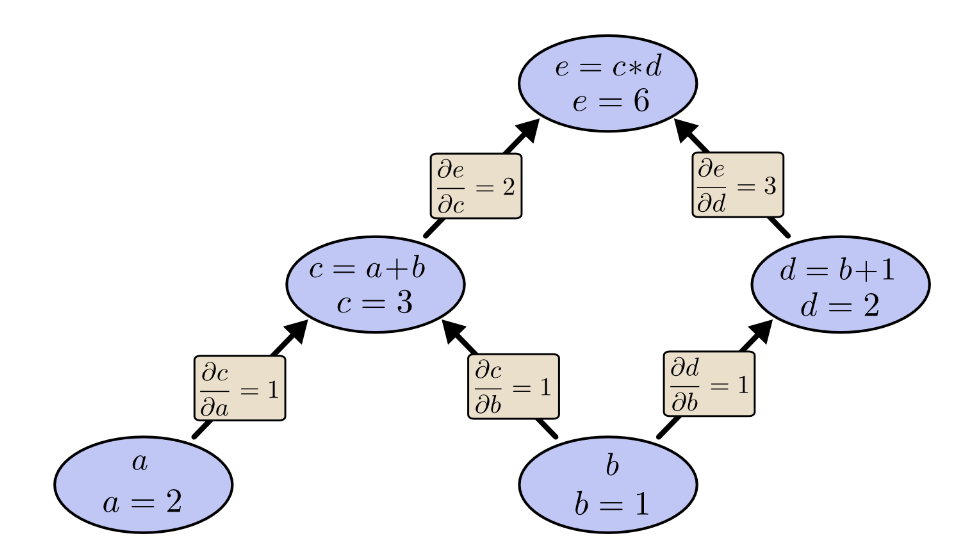

## ***Q4.1*** Implement the `Linear` ($wx+b$) and `LogSoftmax` components below. Insert your code below wherever requested (`# Implement here`). (15 points)

**Hint:** Note that your implementation should be able to accept batched input. Use `np.matmul` carefully. A good rule of thumb is to always be mindful of the shape of the input and the shape that the output must have. If you're not familiar with [broadcasting in NumPy](https://numpy.org/doc/stable/user/basics.broadcasting.html), please first review that.

In [ ]:
class Linear(NNComp):
    def __init__(self, in_dim, out_dim):
        k = 1 / in_dim
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.weight = np.random.uniform(-np.sqrt(k), np.sqrt(k), size = (in_dim, out_dim))
        self.bias = np.random.uniform(-np.sqrt(k), np.sqrt(k), size = out_dim)
        self.backward_context = None
        self.dweight = np.empty_like(self.weight, dtype = np.float64)
        self.dbias = np.empty_like(self.bias, dtype = np.float64)

    def forward(self, x):
        assert np.shape(x)[-1] == self.in_dim
        # Implement here
        # return layer_output = output of the linear layer
        self.backward_context = x
        return np.dot(x,self.weight) + self.bias

    def backward(self, incoming_grad):
        # Implement here
        # incomping_grad = d(loss) / d(layer_output)
        # fill out self.dweight and self.dbias
        # return d(loss) / d(layer_input)
        x = self.backward_context
        self.dweight = np.dot(x.T, incoming_grad)
        self.dbias = np.sum(incoming_grad, axis = 0)
        dlayer_input = np.dot(incoming_grad, self.weight.T)
        return dlayer_input

        #pass

    # components that have learnable parameters need to provide a method to update them based on a learning rate
    def update_parameters(self, lr):
        # Implement here
        self.weight -= lr * self.dweight
        self.bias -= lr * self.dbias
#        pass


class LogSoftmax(NNComp):
    def __init__(self):
        self.backward_context = None

    def forward(self, x):
        # Implement here
        # return log of softmax propabilities
        e_x = np.exp(x - np.max(x, axis = -1, keepdims = True))
        self.backward_context = e_x / np.sum(e_x, axis = -1, keepdims = True)  # Save softmax for use in backward pass
        return np.log(self.backward_context)
        #pass

    def backward(self, incoming_grad):
        # Implement here
        # incoming_grad = d(cross_entropy_loss) / d(log_softmax)
        # ** pay attention that you are calculating log_softmax, not softmax in this function
        # return = d(loss) / d(layer_input)
        # review the broadcasting doc as necessary
        softmax = self.backward_context
        dlayer_input = incoming_grad - np.sum(incoming_grad, axis = -1, keepdims = True) * softmax
        return dlayer_input
        #pass

## ***Q4.2*** Now it's time to build more complex components from the components we have so far! In this part, you'll implement a feedforward neural network with one hidden layer that takes an input of dimension `in_dim`, takes it to the hidden dimension of `hidden_dim`, and outputs the log probabilities over `n_classes`. Essentially you'll be implementing this function: $f(x) = \text{LogSoftmax(Linear(Relu(Linear($x$))))}$. Insert your code below wherever requested (`# Implement here`). (15 points)

**Hint:** Implementing more complex neural networks as a list of basic components is helpful.

In [ ]:
class FeedForwardNetwork(NNComp):
    def __init__(self, in_dim, hidden_dim, n_classes):
        # Implement here
        self.linear1 = Linear(in_dim, hidden_dim)
        self.relu = ReLU()
        self.linear2 = Linear(hidden_dim, n_classes)
        self.logsoftmax = LogSoftmax()
        #pass

    def forward(self, x):
        # Implement here
        x = self.linear1.forward(x)
        x = self.relu.forward(x)
        x = self.linear2.forward(x)
        return self.logsoftmax.forward(x)
        #pass

    def backward(self, incoming_grad):
        # Implement here
        # return the final d(loss) / d(input)
        dloss_dlayer_input = self.logsoftmax.backward(incoming_grad)
        dloss_dlayer_input = self.linear2.backward(dloss_dlayer_input)
        dloss_dlayer_input = self.relu.backward(dloss_dlayer_input)
        return self.linear1.backward(dloss_dlayer_input)
        #pass

## ***Q4.3*** Run the cell below to test your implementation. (5 points)

In [ ]:
# don't change the seed
np.random.seed(0)

my_ffn = FeedForwardNetwork(10, 16, 4)
x = np.array([[1, 2, 3, 1, 2, 3, 1, 2, 3, 7],
              [1, 1, 4, 6, 3, 2, 5, 7, 8, 8]])  # a batch of size 2
y = np.array([[0.0, 1.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])  # gold labels (distribution over classes for each sample): the first instance in the batch belongs to the second class. the second instance in the batch belongs to the fourth class.
model_output = my_ffn.forward(x)
loss = -np.sum(y * model_output) / np.shape(x)[0]  # cross-entropy loss
dloss = -y / np.shape(x)[0]

np.testing.assert_almost_equal(loss, 1.6694167587277589)

expected_output = np.array([[-1.72988805, -1.08436122, -1.22014449,  -1.66394409], [-3.39363728, -1.01780419, -0.6929528, -2.25447229]])
np.testing.assert_almost_equal(model_output, expected_output)

expected_dloss_dinput = np.array([[-0.00724152, -0.00137138, -0.01401658, 0.02887103, 0.02341486, 0.00966052, 0.00279497, -0.03658237,0.00059946, -0.03005935],
                                  [0.04514084, -0.0660606, 0.01502728, 0.00231462, 0.01518657, -0.06244647, -0.03408578, 0.04895532, 0.02186402, 0.02169023]])
np.testing.assert_almost_equal(my_ffn.backward(dloss), expected_dloss_dinput)